In [1]:
from model_PyG import *
from utils import *

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/ealva

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [3]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [4]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [5]:
dataset = "mentos_05" # "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
if (dataset == "mentos_05"):
	train_set = [
		"Orange_1", "Orange_2",
		"Red_1", "Red_2",
		"Yellow_1", "Yellow_2",
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [25]:
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

In [26]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset == "mentos_05":
	for i, ts in enumerate(train_set):
		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values, dtype=torch.long)
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float)

		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, intensity_mean, intensity_cv
		x = torch.tensor(df_nodes.iloc[:, 2:-1].values, dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)
		data = transform(data)
		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 1779
Num. edges:	 1705373
Num. features:	 3
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1776, 1777, 1778],
        [   1,    2,    3,  ..., 1776, 1777, 1778]], device='cuda:0')
tensor([[0.9652, 0.0247, 0.0101],
        [0.7808, 0.0923, 0.1269],
        [0.7863, 0.0924, 0.1212],
        ...,
        [0.6788, 0.2430, 0.0782],
        [0.7170, 0.2163, 0.0667],
        [0.6712, 0.2491, 0.0797]], device='cuda:0')
tensor([ 0.9323, -0.9958, -0.8256,  ...,  1.0000,  1.0000,  1.0000],
       device='cuda:0')
Validate:	 True
Num. nodes:	 1771
Num. edges:	 1635717
Num. features:	 3
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1768, 1769, 1770],
        [   1,    2,    3,  ..., 1768, 1769, 1770]], device='cuda:0')
tensor([[0.9601, 0.0255, 0.0144],
        [0.7392, 0.1096, 0.1513],
        [0.6932, 0.1304, 0.176

In [27]:
train_loader

{'Orange_1': Data(x=[1779, 3], edge_index=[2, 1705373], edge_weight=[1705373]),
 'Orange_2': Data(x=[1771, 3], edge_index=[2, 1635717], edge_weight=[1635717]),
 'Red_1': Data(x=[1777, 3], edge_index=[2, 1626435], edge_weight=[1626435]),
 'Red_2': Data(x=[1772, 3], edge_index=[2, 1680796], edge_weight=[1680796]),
 'Yellow_1': Data(x=[1780, 3], edge_index=[2, 1611464], edge_weight=[1611464]),
 'Yellow_2': Data(x=[1771, 3], edge_index=[2, 1604873], edge_weight=[1604873])}

### Train

In [28]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [29]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for _, data_obj in train_loader.items():
			x = data_obj.x
			edge_index = data_obj.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			z = model(data.x, data.edge_index).detach()
			dict_node_embeddings[ts] = z.cpu().numpy()

	torch.cuda.empty_cache()

	return dict_node_embeddings, list_loss

In [ ]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
mentos_05 0.0001 100 3 128 6


Epoch: 24:  23%|██▎       | 23/100 [03:21<11:16,  8.78s/it, Loss: 0.6950]

### Get embeddings

In [ ]:
dict_node_embeddings

{'Orange_1': array([[-1.76882744e-03, -6.89385384e-02, -1.04401531e-02, ...,
          1.13733038e-02, -3.34586874e-02, -7.39632174e-03],
        [ 1.10907750e-02, -4.28485647e-02, -1.21186832e-02, ...,
          1.25264302e-02, -3.73429283e-02, -7.84862787e-05],
        [ 1.07450560e-02, -4.36259359e-02, -1.21418023e-02, ...,
          1.26021765e-02, -3.69493067e-02, -2.08294019e-04],
        ...,
        [ 1.69516653e-02, -2.84930021e-02, -1.42624872e-02, ...,
          1.77980512e-02, -2.24086344e-02,  7.65283592e-03],
        [ 1.44249545e-02, -3.38916853e-02, -1.37569532e-02, ...,
          1.70301385e-02, -2.35161185e-02,  5.74581511e-03],
        [ 1.73920020e-02, -2.74633616e-02, -1.41926156e-02, ...,
          1.79069191e-02, -2.20041666e-02,  8.15480947e-03]], dtype=float32),
 'Orange_2': array([[-0.00166301, -0.06830456, -0.01009704, ...,  0.01117756,
         -0.03356762, -0.00715165],
        [ 0.01387016, -0.03702757, -0.01227459, ...,  0.01274343,
         -0.03785992, 

### Plot

In [ ]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(10650, 128)


array([[-1.76882744e-03, -6.89385384e-02, -1.04401531e-02, ...,
         1.13733038e-02, -3.34586874e-02, -7.39632174e-03],
       [ 1.10907750e-02, -4.28485647e-02, -1.21186832e-02, ...,
         1.25264302e-02, -3.73429283e-02, -7.84862787e-05],
       [ 1.07450560e-02, -4.36259359e-02, -1.21418023e-02, ...,
         1.26021765e-02, -3.69493067e-02, -2.08294019e-04],
       ...,
       [ 1.66493542e-02, -2.93520037e-02, -1.44274347e-02, ...,
         1.79149322e-02, -2.22154409e-02,  7.31756352e-03],
       [ 2.05099173e-02, -2.10650992e-02, -1.51893059e-02, ...,
         1.91572346e-02, -2.02144124e-02,  1.03408508e-02],
       [ 1.71519052e-02, -2.82328278e-02, -1.45177431e-02, ...,
         1.80871673e-02, -2.18889695e-02,  7.73322210e-03]], dtype=float32)

In [ ]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
    labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

10650
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
list_loss

[1.0420339107513428,
 4.5606818199157715,
 1.1576341390609741,
 1.122269868850708,
 0.7082557678222656,
 1.0115605592727661,
 0.7085696458816528,
 0.7959083318710327,
 0.7386628985404968,
 0.7372065782546997,
 0.7350127100944519,
 0.7061306834220886,
 0.7073156237602234,
 0.7230261564254761,
 0.7141761779785156,
 0.7012550234794617,
 0.6989301443099976,
 0.700874924659729,
 0.7010345458984375,
 0.6996657848358154,
 0.6990237236022949,
 0.6980350017547607,
 0.6959018707275391,
 0.694145143032074,
 0.6935641169548035,
 0.6938328742980957,
 0.6944578886032104,
 0.6946799159049988,
 0.6941744089126587,
 0.69342041015625,
 0.6928762793540955,
 0.6926047205924988,
 0.6925030946731567,
 0.6924804449081421,
 0.6924769282341003,
 0.6924585700035095,
 0.6924222707748413,
 0.6923828125,
 0.6923521757125854,
 0.6923321485519409,
 0.6923179626464844,
 0.6923027038574219,
 0.6922821402549744,
 0.6922570466995239,
 0.692232608795166,
 0.6922143697738647,
 0.6922035217285156,
 0.6921980381011963,
 0.6

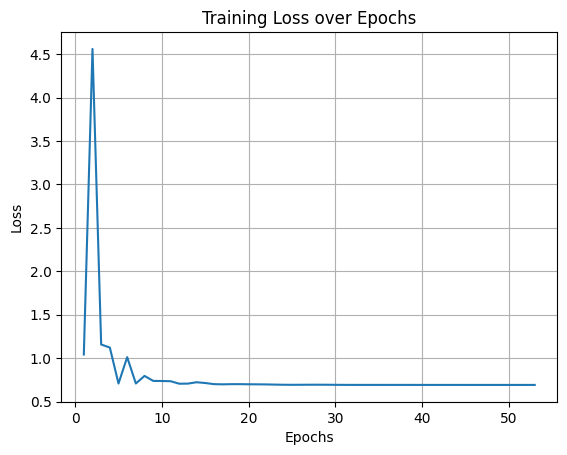

In [ ]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

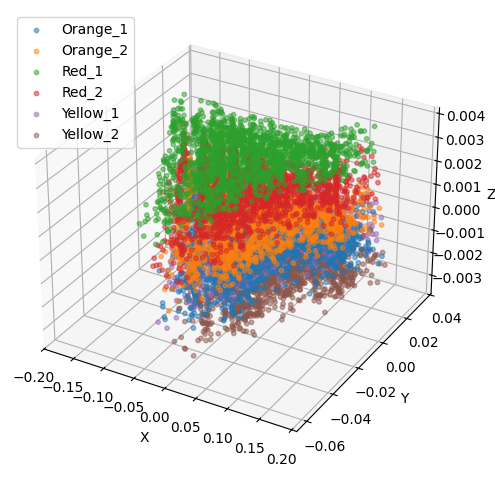

In [ ]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

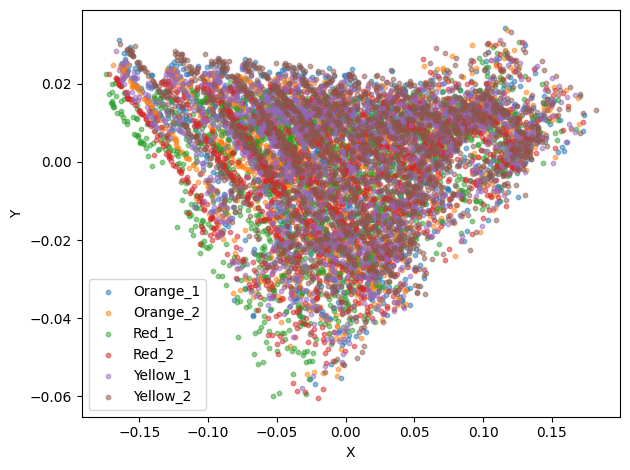

In [ ]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [ ]:
train_set

['Orange_1', 'Orange_2', 'Red_1', 'Red_2', 'Yellow_1', 'Yellow_2']

In [ ]:
# Get node ids

dict_node_id = {}

if dataset == "mentos_05":
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
    for ts in train_set:
        dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'Orange_1': array([   4,   40,   50, ..., 2295, 2300, 2304]),
 'Orange_2': array([   4,   33,   75, ..., 2284, 2296, 2303]),
 'Red_1': array([  13,   33,   50, ..., 2304, 2306, 1393]),
 'Red_2': array([  13,   14,   24, ..., 2278, 2301, 2303]),
 'Yellow_1': array([   4,   13,   28, ..., 2281, 2296, 2306]),
 'Yellow_2': array([   4,   14,   28, ..., 2295, 2301, 2304])}

In [ ]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,Orange_1,Orange_2,Red_1,Red_2,Yellow_1,Yellow_2
0,4,4,70,70,4,78
1,40,50,122,154,102,62
2,50,114,122,154,61,143
3,80,144,80,69,78,724
4,92,50,122,102,50,132
...,...,...,...,...,...,...
1774,2220,2216,2223,2284,2171,2286
1775,2272,2264,2088,2159,2253,2194
1776,2295,2246,2173,2208,2166,2304
1777,2300,2300,2243,2243,2300,2196


In [ ]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

Orange_1 Orange_2


,Orange_1,Orange_2,Red_1,Red_2,Yellow_1,Yellow_2
0,4,4,70,70,4,78
11,143,143,154,150,92,184
16,168,168,33,140,162,75
20,201,201,61,239,142,171
22,214,214,201,274,214,257
...,...,...,...,...,...,...
1760,2020,2020,2197,2134,2142,1860
1764,2089,2089,2273,2177,2004,1881
1770,2152,2152,2088,2159,2253,1805
1777,2300,2300,2243,2243,2300,2196


In [ ]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
df_node_alignment_filter

,Orange_1,Orange_2,Red_1,Red_2,Yellow_1,Yellow_2


In [ ]:
# Comparison (with test_pairs)

if dataset != "mentos_05":
	print(len(test_pairs))
	test_pairs

	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	df_node_alignment[df_node_alignment["mask"] == True]